### How to create a good title for video?

In [114]:
import pandas as pd

british_youtube = pd.read_csv("GBvideos.csv")
canadian_youtube = pd.read_csv("CAvideos.csv")
us_youtube = pd.read_csv("USvideos.csv")

videos = pd.concat([canadian_youtube, british_youtube,us_youtube])
videos.head()

video_id trending_date  \
0  n1WpP7iowLc      17.14.11   
1  0dBIkQ4Mz1M      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  d380meD0W0M      17.14.11   
4  2Vv-BfVoq4g      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id              publish_time  \
0           10  2017-11-10T17:00:03.000Z   
1           23  2017-11-13T17:00:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-12T18:01:41.000Z   
4           10  2017-11-09T11:04:14.000Z   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579   787425   
1  plush|"bad unboxing"|"unboxing"|"fan mail"|"id...   1014651   127794   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434   146035   
3  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...   2095828   132239   
4  edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...  33523622  1634130   

   dislikes  comment_count                                  thumbnail_link  \
0     43420         125882  https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg   
1      1688          13030  https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg   
2      5339           8181  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg   
3      1989          17518  https://i.ytimg.com/vi/d380meD0W0M/default.jpg   
4     21082          85067  https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description  
0  Eminem's new track Walk on Water ft. Beyoncé i...  
1  STill got a lot of packages. Probably will las...  
2  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...  
3  I know it's been a while since we did this sho...  
4  🎧: https://ad.gt/yt-perfect\n💰: https://atlant...

### What makes videos popular?

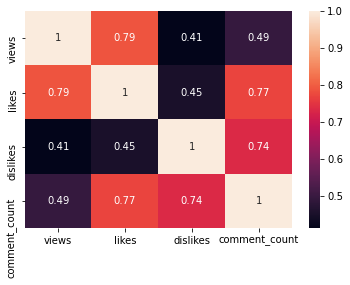

In [115]:
import seaborn as sn
import matplotlib.pyplot as plt


class CorrelationMatrix:
    def __init__(self, df):
        self.df = df

    def draw(self):
        corr_matrix = self.df[['views', 'likes', 'dislikes', 'comment_count']].corr()
        sn.heatmap(corr_matrix, annot=True)
        plt.show()


CorrelationMatrix(videos).draw()

In [116]:
class YoutubeNormalizer:

    def __init__(self, csv):
        self.csv = csv

    def decide_about_popular(self):
        lots_views = self.csv.views.quantile(0.8)
        comments_median = self.csv.comment_count.quantile(0.6)
        lots_of_dislike = self.csv.dislikes.quantile(0.8)
        self.csv['popular'] = 0
        self.csv.loc[(comments_median < self.csv.comment_count) & (self.csv.views > lots_views), 'popular'] = 1
        self.csv.loc[(self.csv.dislikes > lots_of_dislike) & (self.csv.likes > self.csv.dislikes), 'popular'] = 1

    def get_normalized_data(self):
        self.csv.drop_duplicates(subset="title", keep='first', inplace=True)
        self.decide_about_popular()
        title_with_popular = self.csv[['title', 'popular']]
        return title_with_popular


normalized_data = YoutubeNormalizer(videos).get_normalized_data()
normalized_data.head()

title  popular
0         Eminem - Walk On Water (Audio) ft. Beyoncé        1
1                      PLUSH - Bad Unboxing Fan Mail        1
2  Racist Superman | Rudy Mancuso, King Bach & Le...        1
3                           I Dare You: GOING BALD!?        1
4        Ed Sheeran - Perfect (Official Music Video)        1

### Title Normalization

In [117]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
import warnings

warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')

stop = stopwords.words('english')
st = PorterStemmer()


class NormalizedTitle:
    def __init__(self, df):
        self.df = df

    @staticmethod
    def avg_word(sentence):
        words = sentence.split()
        return sum(len(word) for word in words) / len(words)

    def parameters_extraction(self):
        self.df['word_count'] = self.df['title'].apply(lambda x: len(str(x).split(" ")))
        self.df['char_count'] = self.df['title'].str.len()
        self.df['avg_word'] = self.df['title'].apply(lambda x: self.avg_word(x))
        self.df['stopwords'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x in stop]))
        self.df['hastags'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
        self.df['numerics'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

    def text_preparation(self):
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
        self.df['title'] = self.df['title'].str.replace('[^\w\s]', '')
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        freq = pd.Series(' '.join(self.df['title']).split()).value_counts()
        common_words = freq[freq > 250]
        common_words = list(common_words.index)
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))
        rare_words = common_words = freq[freq < 5]
        rare_words = list(common_words.index)
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))
        self.df['title'] = self.df['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
        self.df['title'] = self.df['title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    def process(self):
        self.parameters_extraction()
        self.text_preparation()
        return self.df


normalized_title = NormalizedTitle(normalized_data).process()
normalized_title.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


title  popular  word_count  \
0                        eminem walk water beyoncé        1           8   
1                               bad unbox fan mail        1           6   
2  racist superman rudi mancuso king bach lele pon        1          10   
3                                          dare go        1           5   
4                               ed sheeran perfect        1           7   

   char_count  avg_word  stopwords  hastags  numerics  
0          42  4.375000          0        0         0  
1          29  4.000000          0        0         0  
2          53  4.400000          0        0         0  
3          24  4.000000          0        0         0  
4          43  5.285714          0        0         0

### Title Vectorization

In [118]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, naive_bayes, svm, ensemble


class TitleVectorization:
    def __init__(self, df):
        self.df = df

    def process(self):
        train_df, test_df = train_test_split(
            self.df,
            test_size=0.1,
            stratify=self.df['popular'],
        )
        vectorizer = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1, 2), analyzer="word")
        vectorizer.fit(train_df)
        return train_df, test_df, vectorizer


(train_title_popularity, test_title_popularity, vectorizer) = TitleVectorization(normalized_title).process()

### Classification and metrics

In [119]:
class Classification:
    def __init__(self, train_df, test_df, vectorizer, strategy):
        self.train_df = train_df
        self.test_df = test_df
        self.vectorizer = vectorizer
        if strategy == 'LogisticRegression':
            self.model = LogisticRegression(class_weight='balanced', dual=False)
        elif strategy == 'NAIVE BAYES':
            self.model = naive_bayes.MultinomialNB()
        elif strategy == 'SVM':
            self.model = svm.SVC()
        elif strategy == 'RANDOM FORREST':
            self.model = ensemble.RandomForestClassifier()

    def train(self):
        transformed = vectorizer.transform(self.train_df['title'])
        self.model.fit(transformed, self.train_df['popular'])

    def show_model_statistic(self):
        vectorized = vectorizer.transform(self.test_df['title'])
        predicted = self.model.predict(vectorized)
        target = self.test_df['popular']
        print(metrics.classification_report(target, predicted, digits=4))

### Logistic Regression

In [120]:
logistic_regression_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
                                                    strategy='LogisticRegression')
logistic_regression_classification.train()
logistic_regression_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2337
           1     0.2363    0.9959    0.3819       726

    accuracy                         0.2360      3063
   macro avg     0.1181    0.4979    0.1910      3063
weighted avg     0.0560    0.2360    0.0905      3063



### NAIVE BAYES

In [121]:
naive_bayes_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='NAIVE BAYES')
naive_bayes_classification.train()
naive_bayes_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7630    1.0000    0.8656      2337
           1     0.0000    0.0000    0.0000       726

    accuracy                         0.7630      3063
   macro avg     0.3815    0.5000    0.4328      3063
weighted avg     0.5821    0.7630    0.6604      3063



### SVM

In [122]:
svm_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='SVM')
svm_classification.train()
svm_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7630    1.0000    0.8656      2337
           1     0.0000    0.0000    0.0000       726

    accuracy                         0.7630      3063
   macro avg     0.3815    0.5000    0.4328      3063
weighted avg     0.5821    0.7630    0.6604      3063



### RANDOM FORREST

In [123]:
random_forest_tree = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='RANDOM FORREST')
random_forest_tree.train()
random_forest_tree.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7630    1.0000    0.8656      2337
           1     0.0000    0.0000    0.0000       726

    accuracy                         0.7630      3063
   macro avg     0.3815    0.5000    0.4328      3063
weighted avg     0.5821    0.7630    0.6604      3063

